###  Imports and Configuration

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

from mf_npe.simulator.high_fidelity_hh import MarkovHHSimulator
from mf_npe.utils.utils import set_global_seed, summarize_voltage, dump_pickle

# ------------------- Configuration -------------------
SEED = 1
SAVE_DIR = Path("./outputs/single_hf_trace/")
SAVE_DIR.mkdir(parents=True, exist_ok=True) 
OUT_FILE_NPZ = SAVE_DIR / "markov_ground_truth_trace.npz"
OUT_FILE_PKL = SAVE_DIR / "markov_ground_truth_trace.pkl"
# -----------------------------------------------------

# seed for reproducibility
set_global_seed(SEED)
print(f"Global seed set to {SEED}")

Global seed set to 1


### Define Ground-Truth Parameters

In [2]:
# The canonical Hodgkin-Huxley conductances (mS/cm²)
gNa_true = 120.0
gK_true  = 36.0
gL_true  = 0.3
theta_true = torch.tensor([gNa_true, gK_true, gL_true], dtype=torch.float32)

print(f"Using ground-truth parameter set (g_Na, g_K, g_L):")
print(theta_true.numpy())

Using ground-truth parameter set (g_Na, g_K, g_L):
[120.   36.    0.3]


### Run the High-Fidelity Simulator

In [7]:
# Unpack the parameters
gbar_Na, gbar_K, gbar_L = theta_true.tolist()

# We use the specific conductances and default channel counts (NNa=6000, NK=1800)
simulator = MarkovHHSimulator(g_na=gbar_Na, g_k=gbar_K, g_l=gbar_L)

t_array = np.arange(0.0, 50.01, 0.01)  # Simulation time

def stimulus_current(t: float) -> float:
    """Step current: 10 µA·cm⁻² from 10 to 30 ms."""
    return 10.0 if 10.0 <= t < 30.0 else 0.0

# Run the simulation
print("Running high-fidelity simulation (this may take a minute)...")
start_time = time.time()
results = simulator.simulate(t_array, stimulus_current)
elapsed_time = time.time() - start_time
print(f"Simulation finished in {elapsed_time:.4f} seconds.")

t_out = results[:, 0]
v_out = results[:, 1]

Running high-fidelity simulation (this may take a minute)...
Simulation finished in 145.1067 seconds.


### Summary Statistics

In [8]:
summary_stats = summarize_voltage(t_out, v_out)

print("Calculated Summary Statistics:")
print(f"  Spike Count: {summary_stats[0]}")
print(f"  Mean Rest:   {summary_stats[1]:.2f} mV")
print(f"  Std Rest:    {summary_stats[2]:.2f} mV")
print(f"  Mean Stim:   {summary_stats[3]:.2f} mV")

Calculated Summary Statistics:
  Spike Count: 2.0
  Mean Rest:   -66.03 mV
  Std Rest:    1.12 mV
  Mean Stim:   -50.96 mV


### Save the Results

In [9]:
np.savez(
    OUT_FILE_NPZ,
    t=t_out,
    V_hi=v_out,
    summary=summary_stats,
    theta=theta_true.numpy(),
    seed=SEED,
    elapsed_seconds=elapsed_time
)
print(f"Saved NPZ results to: {OUT_FILE_NPZ}")

results_dict = {
    "t": t_out,
    "V_hi": v_out,
    "theta": theta_true.numpy(),
    "seed": SEED,
    "elapsed_seconds": elapsed_time
}
dump_pickle(OUT_FILE_PKL, results_dict)

Saved NPZ results to: outputs\single_hf_trace\markov_ground_truth_trace.npz
Saved variable to outputs\single_hf_trace\markov_ground_truth_trace.pkl


### Plot and Save the Voltage Trace

Plot saved successfully to: outputs\single_hf_trace\hf_voltage_trace.png


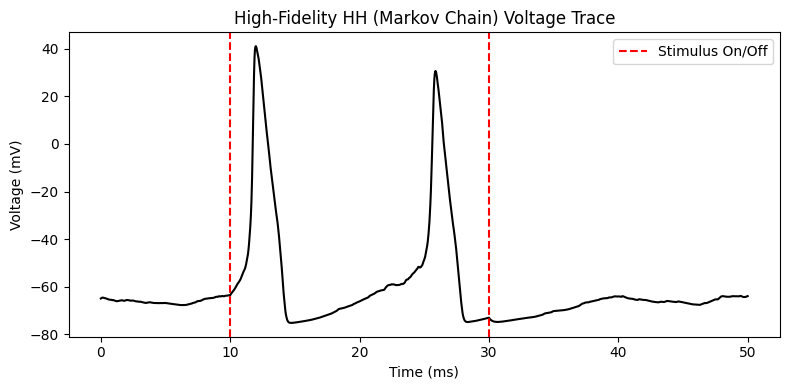

In [10]:
# --- Setup the plot ---
plt.figure(figsize=(8, 4))
plt.plot(t_out, v_out, lw=1.5, color="black")

# Add lines and labels for the stimulus window
plt.axvline(10.0, color="red", linestyle="--", label="Stimulus On/Off")
plt.axvline(30.0, color="red", linestyle="--")

plt.title(f"High-Fidelity HH (Markov Chain) Voltage Trace")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
#plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()


FIGURE_SAVE_PATH = SAVE_DIR / "hf_voltage_trace.png"
plt.savefig(FIGURE_SAVE_PATH, dpi=300, bbox_inches='tight')
print(f"Plot saved successfully to: {FIGURE_SAVE_PATH}")
plt.show()